<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/huggingface/Custom_Progress_Callback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{huggingface_wandb} -->

# Visualize LLM training progress with Wandb Tables

In this example we will see how to instrument a custom [callback](https://huggingface.co/docs/transformers/main_classes/callback) for the huggingface [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) to periodically visualize model predictions using Weight & Biases [Tables](https://wandb.ai/site/tables)


<img src="https://i.imgur.com/vnejHGh.png" width="800">

<!--- @wandbcode{huggingface_wandb} -->



## 🤔 Why should I use W&B?

<img src="https://wandb.me/mini-diagram" width="650">

- **Unified dashboard**: Central repository for all your model metrics and predictions
- **Lightweight**: No code changes required to integrate with Hugging Face
- **Accessible**: Free for individuals and academic teams
- **Secure**: All projects are private by default
- **Trusted**: Used by machine learning teams at OpenAI, Toyota, Lyft and more

Think of W&B like GitHub for machine learning models— save machine learning experiments to your private, hosted dashboard. Experiment quickly with the confidence that all the versions of your models are saved for you, no matter where you're running your scripts.

W&B lightweight integrations works with any Python script, and all you need to do is sign up for a free W&B account to start tracking and visualizing your models.

# 🚀 Install, Import, and Log in


To get started with this example you will need to Install the Transformers, Weights & Biases, datasets libraries.
- [Hugging Face Transformers](https://github.com/huggingface/transformers)
- [Weights & Biases](https://docs.wandb.com/)
- [Huggingface Datasets](https://github.com/huggingface/datasets)

**Uncomment the following cell install the libraries.**

In [ ]:
# ! pip install -qqq datasets "transformers[torch]" wandb

## 🖊️ [Sign up for a free account →](https://app.wandb.ai/login?signup=true)

## 🔑 Put in your API key

Once you've signed up, run the next cell and click on the link to get your API key and authenticate this notebook.

In [ ]:
import wandb
wandb.login()

# Train a language model

In this notebook, we'll see how to train a [🤗 Transformers](https://github.com/huggingface/transformers) model on the Causal language modeling task i.e. the model has to predict the next token in the sentence (so the labels are the same as the inputs shifted to the right). To make sure the model does not cheat, it gets an attention mask that will prevent it to access the tokens after token i when trying to predict the token i+1 in the sentence.

We will see how to load and preprocess the dataset for the task and train a model on it using the `Trainer` API.
We will be building a custom trainer callback to visualize the model predictions using Weights & Biases Tables by priodically logging the predictions to the table.

## Prepare the dataset

we will use the [Wikitext 2](https://paperswithcode.com/dataset/wikitext-2) dataset as an example for this task.

In [ ]:
from datasets import load_dataset
datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')

# look at a sample from the train dataset
datasets["train"][10]


For causal language modeling (CLM) task we are going to take all the texts in our dataset and concatenate them after they are tokenized.
Then we split them in examples of a certain sequence length. This way the model will receive chunks of contiguous text that may look like:
```
part of text 1
```
or
```
end of text 1 [BOS_TOKEN] beginning of text 2
```
depending on whether they span over several of the original texts in the dataset or not. The labels will be the same as the inputs, shifted to the left.

We will use the [`gpt2`](https://huggingface.co/gpt2) architecture for this example. You can pick any of the checkpoints listed [here](https://huggingface.co/models?filter=causal-lm) instead.

In [ ]:
MODEL_NAME ="gpt2"

from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

We can now call the tokenizer on all our texts using the [`map`](https://huggingface.co/docs/datasets/process#map) method from the Datasets library.

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

Next, we need to concatenate all our texts together then split the result in small chunks of a certain `block_size`. Here we will use a block_size of `128`.

In [ ]:
BLOCK_SIZE = 128

def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // BLOCK_SIZE) * BLOCK_SIZE
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + BLOCK_SIZE] for i in range(0, total_length, BLOCK_SIZE)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result


lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

# look at a sample from the preprocessed dataset
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

## Model & TrainingArguments

Now that we have our dataset prepared we are readt to instantiate the model and the Training Arguments.
For simpilicity we will train the model for 3 epochs and log the model predictions and metrics after each epoch.

In [ ]:
from transformers import AutoConfig, AutoModelForCausalLM
from transformers import Trainer, TrainingArguments

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME,)

training_args = TrainingArguments(
    f"{MODEL_NAME}-wikitext2",
    evaluation_strategy="epoch",
    num_train_epochs=3,
    learning_rate=2e-5,
    do_train=True,
    do_eval=True,
    weight_decay=0.01,
    logging_strategy="epoch",
    fp16=True,
    dataloader_num_workers=4,

)

## WandbPredictionProgressCallback

To periodically visualize the results we will subclass the [`WandbCallback`](https://huggingface.co/docs/transformers/main_classes/callback#transformers.integrations.WandbCallback) from the transformers library. This callback already instrumented to log model metrics, checkpoints and system metrics to Weights & Biases.

Here we will customize the callback to periodically log model predictions and labels to a `wandb.Table` so that we can visualize the model predictions as the training progresses. To do this, we will also need to pass the trainier and tokenizer to our callback in order to predict over the validation dataset.

In [ ]:
from transformers.integrations import WandbCallback
import pandas as pd
import os

os.environ["WANDB_LOG_MODEL"] = "checkpoint"

def decode_predictions(tokenizer, predictions):
    labels = tokenizer.batch_decode(predictions.label_ids)
    prediction_text = tokenizer.batch_decode(predictions.predictions.argmax(axis=-1))
    return {"labels": labels, "predictions": prediction_text}


class WandbPredictionProgressCallback(WandbCallback):
    """Custom WandbCallback to log model predictions during training.

    This callback logs model predictions and labels to a wandb.Table at each logging step during training.
    It allows to visualize the model predictions as the training progresses.

    Attributes:
        trainer (Trainer): The Hugging Face Trainer instance.
        tokenizer (AutoTokenizer): The tokenizer associated with the model.
        sample_dataset (Dataset): A subset of the validation dataset for generating predictions.
        num_samples (int, optional): Number of samples to select from the validation dataset for generating predictions. Defaults to 100.
    """

    def __init__(self, trainer, tokenizer, val_dataset, num_samples=100, freq=2):
        """Initializes the WandbPredictionProgressCallback instance.

        Args:
            trainer (Trainer): The Hugging Face Trainer instance.
            tokenizer (AutoTokenizer): The tokenizer associated with the model.
            val_dataset (Dataset): The validation dataset.
            num_samples (int, optional): Number of samples to select from the validation dataset for generating predictions. Defaults to 100.
            freq (int, optional): Control the frequency of logging. Defaults to 2.
        """
        super().__init__()
        self.trainer = trainer
        self.tokenizer = tokenizer
        self.sample_dataset = val_dataset.select(range(num_samples))
        self.freq = freq


    def on_evaluate(self, args, state, control,  **kwargs):
        super().on_evaluate(args, state, control, **kwargs)
        # control the frequency of logging by logging the predictions every `freq` epochs
        if state.epoch % self.freq == 0:
          # generate predictions
          predictions = self.trainer.predict(self.sample_dataset)
          # decode predictions and labels
          predictions = decode_predictions(self.tokenizer, predictions)
          # add predictions to a wandb.Table
          predictions_df = pd.DataFrame(predictions)
          predictions_df["epoch"] = state.epoch
          records_table = self._wandb.Table(dataframe=predictions_df)
          # log the table to wandb
          self._wandb.log({"sample_predictions": records_table})


## Trainer

First we inistantiate the [`Trainer`] class with the model, training arguments, and the train, eval datasets. Since our callback needs to store predictions after each evaluation we will be passing the trainer to callback and then adding the callback to the trainer.

**Note**: Here we donot add the callback while inistatiating the `Trainer` but instead we will use the `add_callback` method to include the callback in the trainer after instantiation.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],

)


progress_callback = WandbPredictionProgressCallback(trainer, tokenizer, lm_datasets["validation"], 10)
trainer.add_callback(progress_callback)

## Training

And that's it, we are ready to train the model and visualize the predictions.

In [ ]:
trainer.train()

# 👀 Visualize results in dashboard

Click the link printed out above, or go to [wandb.ai](https://app.wandb.ai) to see your results stream in live. The link to see your run in the browser will appear after all the dependencies are loaded — look for the following output:

```
Tracking run with wandb version <wandb-verison>
Run data is saved locally in <local-logs-path>
Syncing run <run-name> to Weights & Biases (docs)
View project at <project-url>
View run at <run-url>
```

Click on the <run-url> to visualize the sample model predictions epoch. You should see a table similar to the one shown in the screenshot below.

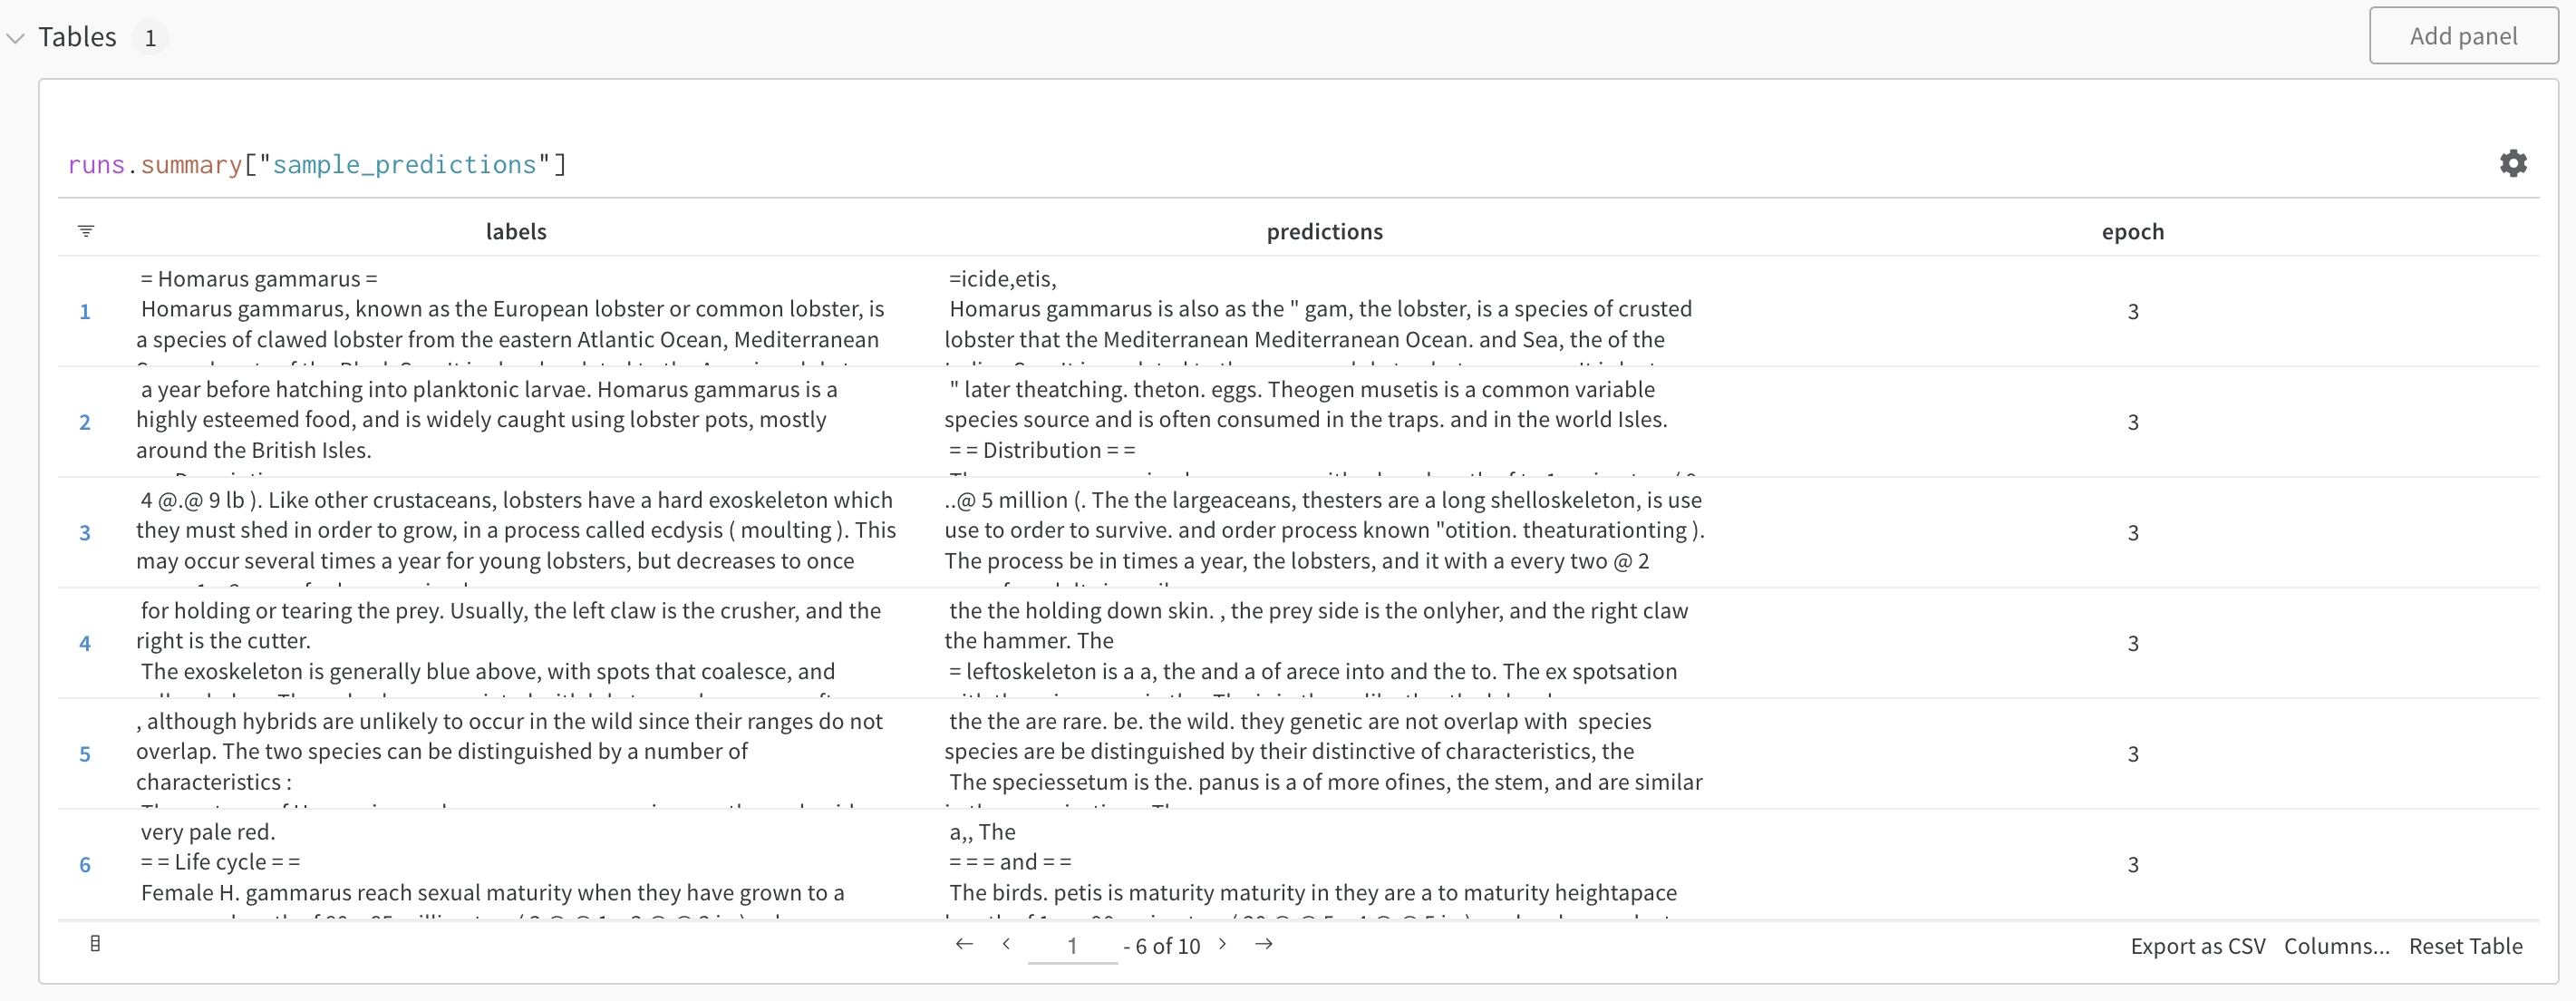


## 📈 Track key information effortlessly by default
Weights & Biases saves a new run for each experiment. Here's the information that gets saved by default:
- **Hyperparameters**: Settings for your model are saved in Config
- **Model Metrics**: Time series data of metrics streaming in are saved in Log
- **Terminal Logs**: Command line outputs are saved and available in a tab
- **System Metrics**: GPU and CPU utilization, memory, temperature etc.




## 🤓 Learn more!
- [Documentation](https://docs.wandb.com/huggingface): docs on the Weights & Biases and Hugging Face integration
- [Videos](http://wandb.me/youtube): tutorials, interviews with practitioners, and more on our YouTube channel
- Contact: Message us at contact@wandb.com with questions 